# Tutorial/Walkthrough of the multi_plot class and what you can do with it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import trident
from IPython.display import Image
from sys import path
path.insert(0, "../multi_plot_movie/")
import multi_plot

from center_finder import find_center

In [2]:
from importlib import reload
reload(multi_plot)

<module 'multi_plot' from '../multi_plot_movie/multi_plot.py'>

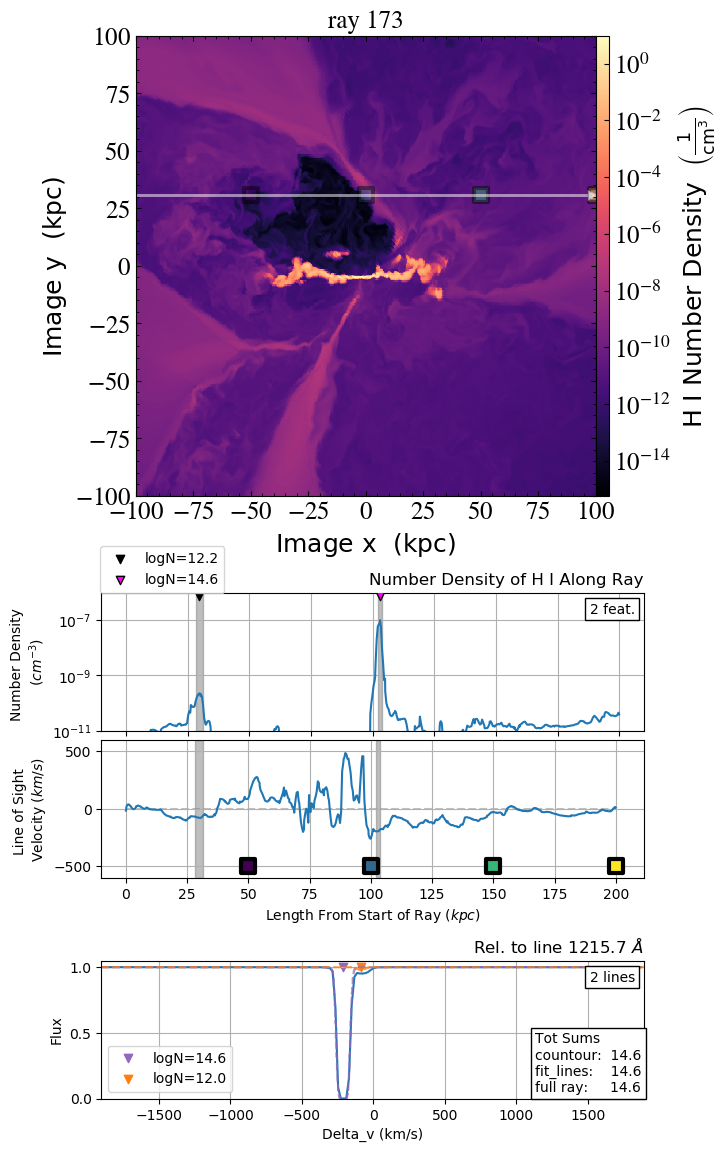

In [3]:
Image('sample_mp.png')

First define parameters and file paths to dataset as well as ray

In [4]:
ds_fname = "/mnt/gs18/scratch/users/boydbre1/"+ \
           "cosmological/foggie/RD0036/RD0036"

ray_fname="/mnt/gs18/scratch/users/boydbre1/" + \
          "multiplot_movie/foggie/RD0036/movie_200kpc/rays/ray173.h5"

#center finder first tries to find the given ds (RD0036 in this case)
#in center_normal_track.dat and use the saved values
#otherwise it calculates them 
center, norm_vec, redshift, bulk_vel = find_center(ds_fname)

Call the `multi_plot` class with the defined parameters

In [5]:
mp = multi_plot.multi_plot(ds_fname, ray_fname, 
                ion_name='H I',        # ion to look at
                north_vector=norm_vec, # vector poiting along galaxy's axis of rotaion
                center_gal=center,     # coordinates of galaxy's center
                wavelength_width=20,   # width of spectra plot in wavelength space
                redshift=redshift,     # redshift of simulation
                use_spectacle=True,    # whether to fit spectra with spectacle
                plot_spectacle=False)   # whether to plot spectacle fits on spectra

yt : [ERROR    ] 2019-08-09 13:18:51,527 Missing omega_radiation in parameter file definition!


<Figure size 720x720 with 0 Axes>

# Computing column densities 
Currently there are three methods used by the `multi_plot` class:

* Contour method `mp.contour`
* Fitting method `mp.use_spectacle`
* Full Sum method

The Contour method uses code constructed by Hillary Egan and can be found on bitbucket or maybe I'll add it to this Repo. The method works by using an initial cutoff (which is roughly the mean background density for the given ion) to define regions in numberdensity where there is at least one absorber. Then for a given region, it finds the maximum number density and sets the cutoff to be a fraction of that (currently 0.5). Then intervals are defined as continuous regions where the number density is above this new cutoff. Then intervals are discared if their column density is too small (default is LogN>12.0 see `spectacle_defaults` for altering this).  

The Fitting method extracts absorbers by trying to fit the absorption spectra created by trident machinery. The fitting is done by using the spectacle libray and the type of features it attempts to fit to the spectra can be altered by setting the `spectacle_defaults`. Some defaults parameters are automatically set when initializing the class. 

The last method is the simplest method. It simply sums the total column density of the light ray and returns that value. It doesn't attempt to extract any individual features or any other paramet

### How to get Absorption information

If all you want is the column densities then you can use `mp.compute_col_density` and take the first object returned which will have a list of column densities computed using the contour method, fitting method, and then the full sum.

In [6]:
col_densities, txt, lines, n_fitted = mp.compute_col_density() 
contour_cd, fitted_cd, full_sum_cd = col_densities

#print out values
print("Total Column Density (LogN with N in cm^-2)")
print(f"Contour method: {contour_cd:.2f}")
print(f"Fitted method: {fitted_cd:.2f}")
print(f"Full Sum method: {full_sum_cd:.2f}")

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2849.00it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -227.723 km / s (1215.67 Angstrom)
    Column density: 13.735, (5.4324e+13 1 / cm2)
    Doppler width: 55.7102 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -37.9419 km / s (1215.67 Angstrom)
    Column density: 11.9713, (1.17847e+12 1 / cm2)
    Doppler width: 32.6521 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -75.8886 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s
/mnt/home/boydbre1/local/yt-conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
spectacle [WARNING ]: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.


Total Column Density (LogN with N in cm^-2)
Contour method: 14.58
Fitted method: 14.56
Full Sum method: 14.64


the `multi_plot` class can give more than just the total column densities. For the first two methods, each absorption feature can be returned using `mp.compute_col_density` and `mp.get_contour_intervals`

Once you have the intervals from `mp.get_contour_intervals` you can use them to access any of the fields in the ray (which can be accessed through `mp.ray`). In this example we get the velocity of the absorption feature as well as it's column density

In [7]:
#for the contour method
intervals, cont_lcd = mp.get_contour_intervals()

print(f"The contour method found {len(cont_lcd)} features:")
for inter, lcd in zip(intervals, cont_lcd):
    #get the beginning and ending index of the interval
    b, e = inter
    
    #find average velocity of feature (along ray)
    velocity_los = mp.ray.data['velocity_los'].in_units('km/s')
    avg_vel = np.mean( velocity_los[b:e] )
    
    print(f"LogN={lcd:.2f} with a velocity of {avg_vel:.0f} km/s")
    

The contour method found 2 features:
LogN=12.23 with a velocity of -75 km/s km/s
LogN=14.57 with a velocity of -195 km/s km/s


`mp.compute_col_density()` outputs the spectacle's Spectral1D class for the largest absorbers found using the fitting method (it is the third output). This holds all the information about the 

In [8]:
#for the fitting method
col_densities, txt, largest_lines, n_fitted = mp.compute_col_density() 

#the txt is meant to be written to a text box when creating the full multi-plot

#largest lines hold spectacle models for the largest absorbers (max of 3)
print(f"The Fitting method found {n_fitted} lines/features")

for line_mod in largest_lines:
    lcd = line_mod.lines[0].column_density.value
    delta_vel = line_mod.lines[0].delta_v.value
    print(f"LogN={lcd:.2f} with a velocity of {delta_vel:.0f} km/s")

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2871.07it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -227.723 km / s (1215.67 Angstrom)
    Column density: 13.735, (5.4324e+13 1 / cm2)
    Doppler width: 55.7102 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -37.9419 km / s (1215.67 Angstrom)
    Column density: 11.9713, (1.17847e+12 1 / cm2)
    Doppler width: 32.6521 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -75.8886 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s


The Fitting method found 2 lines/features
LogN=14.56 with a velocity of -209 km/s
LogN=12.00 with a velocity of -84 km/s


## Creating a slice

multi plot will automatically create a slice of ion's number density with the right orientation based on the given `north_vector` and the given ray. Creating the slice can take a couple minutes if the simulation is large or has very high resolution.

The slice is created such that it is in the plane of the ray and so that the "up"/Z direction is pointing in the same direction as the galaxy's axis of rotation (perpendicular to the disk).

The ray is annotated on the slice so you can see what physical features are being hit by the ray. Markers are also plotted if `mp.markers` is set to True (defaulted to true when class is initialized). These markers are there to make it easy to look from the slice to the number density and line of site velocity plots

Parsing Hierarchy : 100%|██████████| 5160/5160 [00:00<00:00, 5237.75it/s]
yt : [WARNING  ] 2019-08-09 13:19:02,349 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 13:19:02,352 Field ('gas', 'H_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 13:19:02,354 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 13:19:02,356 Field ('gas', 'H_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 13:19:02,358 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 13:19:02,360 Field ('gas', 'H_mass') already exists. Not clobbering.



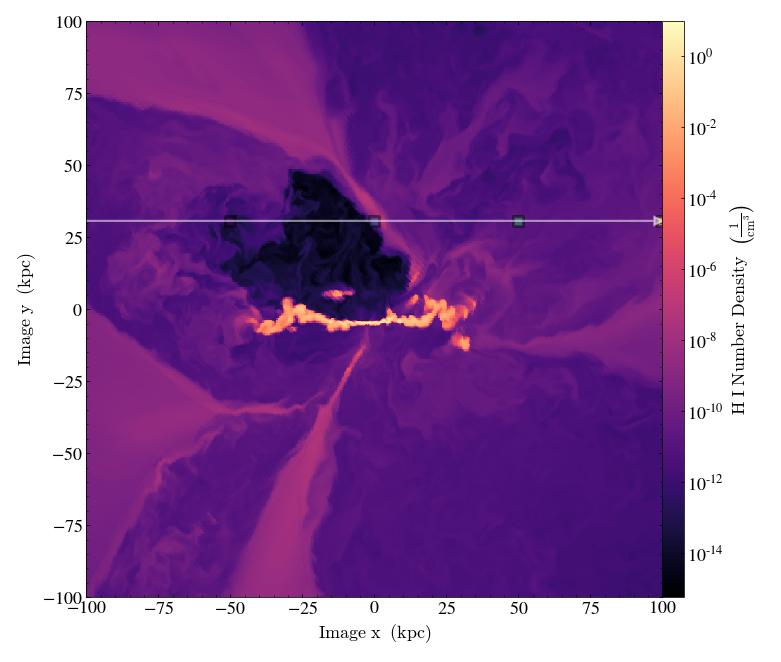

In [9]:
mp.create_slice()

This is then saved and can be interacted with like a regular YT Slice plot


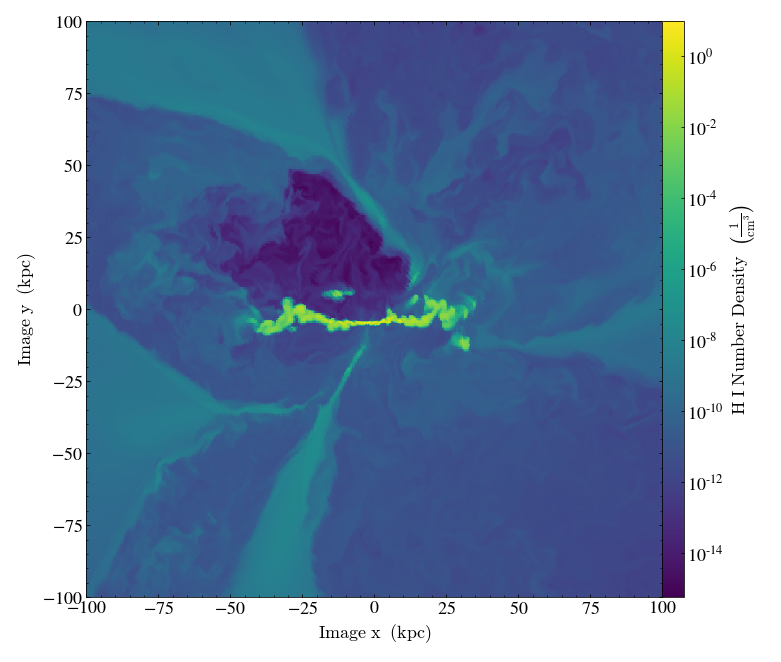

In [10]:
#add a title
mp.slice.annotate_title("A Nice Title")

# change the color map
mp.slice.set_cmap('H_p0_number_density', 'viridis')

# clear all annotations
mp.slice.annotate_clear()

You can re add ray/marker annotaions to the slice by using the mp.add_annotations


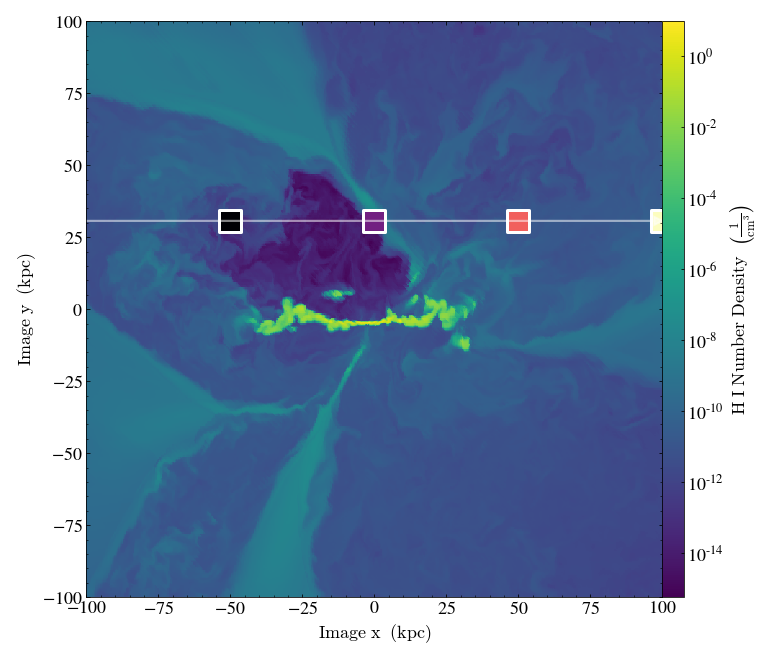

In [11]:
#change some of the marker properties
mp.mark_kwargs
mp.mark_kwargs.update({"s": 500, "edgecolors":'white', "alpha":1})
mp.marker_cmap = "magma"
mp.add_annotations()
mp.slice


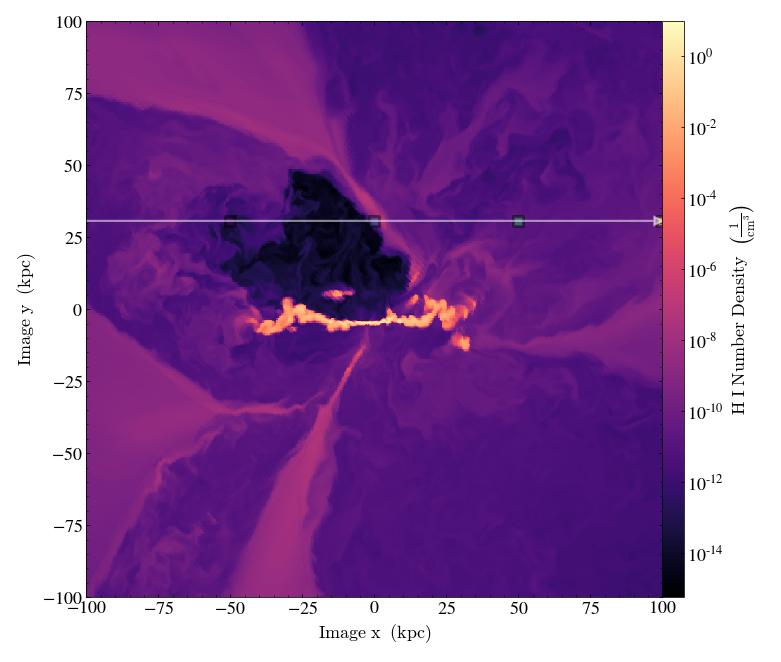

In [12]:
# rest markers and slice back to default
mp.mark_kwargs =  {'alpha' : 0.45,
                   's' : 100,
                   'edgecolors' : 'black',
                   'linewidth' : 3}
mp.marker_cmap = 'viridis'
mp.slice.annotate_clear()
mp.add_annotations()

mp.slice.set_cmap('H_p0_number_density', 'magma')

## Number Density and Line of Sight Velocity Plots
How to make plots of number density and line of sight velocity along light ray

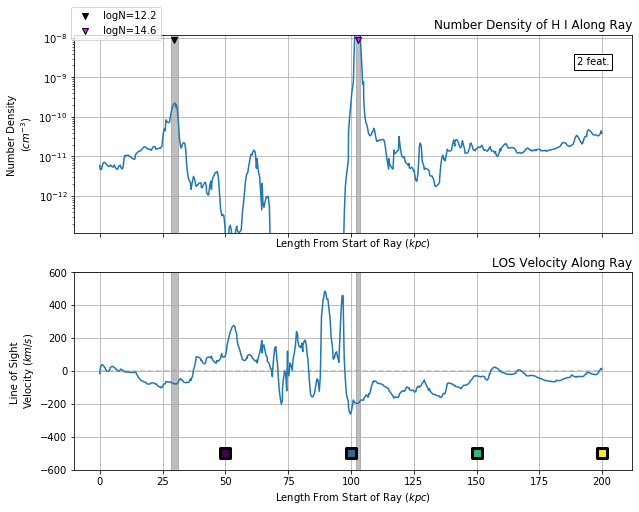

In [13]:
#first create fig and axes
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), sharex=True)

#plot without the contouring method
mp.contour=False
mp.plot_num_dense_los_vel(ax_num_dense=ax1, ax_los_velocity=ax2)

setting `mp.countour` to true and the class will calculate the absorption features the countour method finds and plot the intervals. It will return the number of features found in the top right. Additionally the largest absorbers (max of 3) will be marked by a triangle and their Log Column Density will be reported

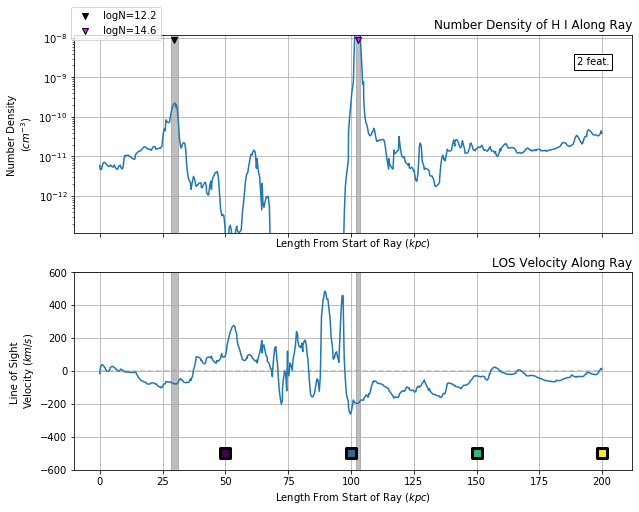

In [14]:
#clear the axes
ax1.clear(); ax2.clear()

#set contour to true and replot everything
mp.contour=True
mp.plot_num_dense_los_vel(ax_num_dense=ax1, ax_los_velocity=ax2)
fig

The axes and figure can now be manipulated like any regular matplotlib figure/axes. In addition to access the pure number density or line of sight velocity you can look at the `"H_p0_number_density"` and `"velocity_los"` fields in `mp.ray`

## Spectra Plots

Absorption spectra plots are made using the trident library and then the plots can be fit, as mentioned before, by using the spectacle library.

Trident can (or will very soon) output the spectra in wavelength space or velocity space. Often velocity space is more useful for comparing with other data and so the multi_plot class defaults to using velocity (though currently wavelength is always made then converted to velocity). 

Adding line - H I 912 [911.763300 A]: : 100%|██████████| 564/564 [00:00<00:00, 3191.99it/s]


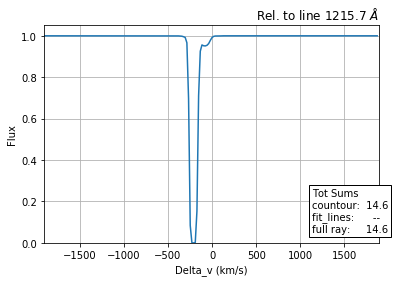

In [15]:
fig, ax = plt.subplots()
mp.use_spectacle=False
wavelength, velocity, flux = mp.plot_spect_vel(ax_vel=ax)

the wavelength, velocity, and flux created by using trident is output for an easy way to look at the spectra with different tools or to plot it in new ways.

We can additionally add more absorption features to the spectra by altering the `mp.ion_list`. and the range/center of the plot can be altered by changing `mp.wavelength_width` and `mp.wavelength_center`

Adding continuum - Ly C [912.323360 A]: : 100%|██████████| 15/15 [00:00<00:00, 2827.49it/s]


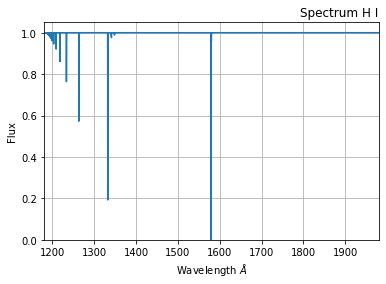

In [16]:
ax.clear()

#append more ions to add to spectra
mp.ion_list.append('C IV')
mp.ion_list.append('O VI')

#increase the width of the window we look at
mp.wavelength_width = 800

#this time look in wavelength space
mp.plot_spect_vel(ax_spect=ax)
fig

There is also an option to look at a single line of the main ion (for example HI 1216). This is especially useful when fitting lines with spectacle and is used internally when fitting with spectacle. The width of this specra is automatically increased so that the tails of the plot go to one, otherwise fitting is near impossible

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2894.83it/s]


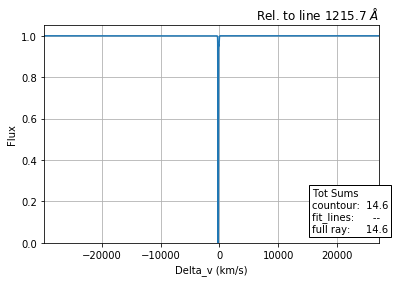

In [17]:
ax.clear()

mp.plot_spect_vel(ax_vel=ax, single_line='H I 1216')
fig

Now lets actually try and use spectacle to fit the lines. Set `mp.use_spectacle` to `True` and the multi_plot class will automatially fit the strongest line of the ion (1216 for HI, 1032 for OVI, etc). If we also set `mp.plot_spectcle` to `True`, multi_plot will plot the strongest lines that it finds (max of 3) on top of the spectra.

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2645.13it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -227.723 km / s (1215.67 Angstrom)
    Column density: 13.735, (5.4324e+13 1 / cm2)
    Doppler width: 55.7102 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -37.9419 km / s (1215.67 Angstrom)
    Column density: 11.9713, (1.17847e+12 1 / cm2)
    Doppler width: 32.6521 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -75.8886 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s
/mnt/home/boydbre1/local/yt-conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
spectacle [WARNING ]: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.
Adding

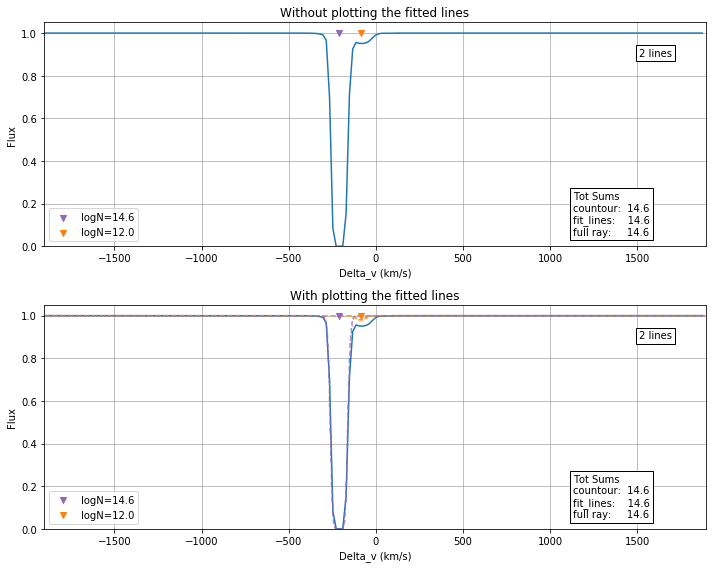

In [18]:
#create new figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

#remove other ions from list so they won't be plotted
mp.ion_list=['H I']
mp.wavelength_width = 20
#set multiplot to try and fit the lines
mp.use_spectacle=True
mp.plot_spectacle=False
#plot the spectra and replace the default title
mp.plot_spect_vel(ax_vel=ax1)
ax1.set_title("", loc='right')
ax1.set_title("Without plotting the fitted lines")

#now set multi_plot to also plot the fits
mp.plot_spectacle = True

#plot the spectra and replace the default title
mp.plot_spect_vel(ax_vel=ax2)
ax2.set_title("", loc='right')
ax2.set_title("With plotting the fitted lines")

fig.tight_layout()

The above plot has quite a bit going on but each part can be explained. 
* The legend in the bottom left with the triangles is marking the largest lines that spectacle fit and reports their Log column density (with N in cm^-2). 
* The top right is simply reporting the total number of lines that were fit to this spectra. 
* Finally, the bottom right lists the total column density for the ray calculated using the three methods descibed above

## The Whole Shabang

Combining pretty much all these features, we can create the multi_plot that makes it easy to look from the slice of data we're looking at, to the number desnity/line of sight velocity and finally the spectra that holds the only information that observers have. 

There is a lot of information packed in this plot and can be overwhelming at times. Different features can be turned off (like plotting spectacle or the contour method) if there seems to be too much going on.

But to create the multi_plot all you have to do is get your settings the way you want them and then call `mp.create_multi_plot`. it is automatically plotted to mp.fig which is just a matpotlib figure

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2883.81it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -227.723 km / s (1215.67 Angstrom)
    Column density: 13.735, (5.4324e+13 1 / cm2)
    Doppler width: 55.7102 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -37.9419 km / s (1215.67 Angstrom)
    Column density: 11.9713, (1.17847e+12 1 / cm2)
    Doppler width: 32.6521 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -75.8886 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s



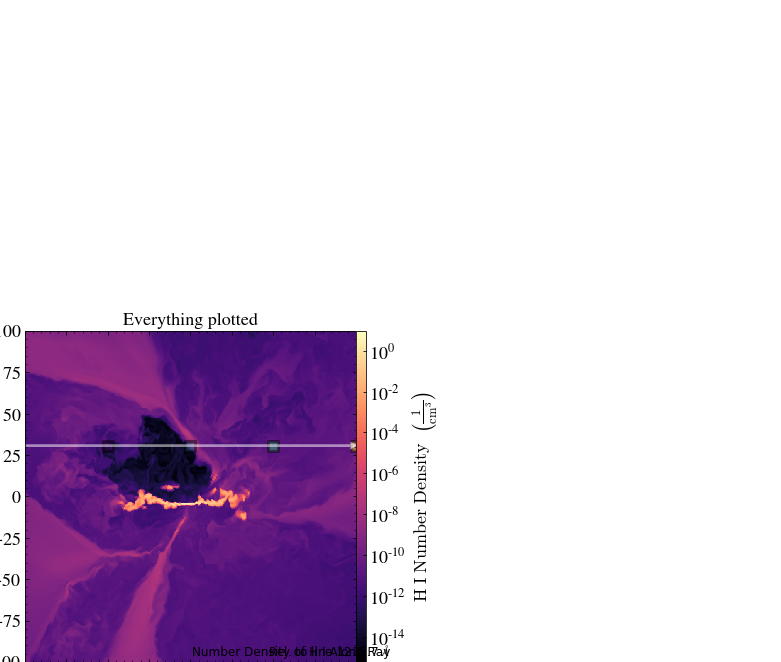

In [19]:
mp.create_multi_plot()
# for some reason if create_slice and create_multi_plot are called in 
# different cells then the slice will appear blank until you interact with it
mp.slice.annotate_title("Everything plotted")

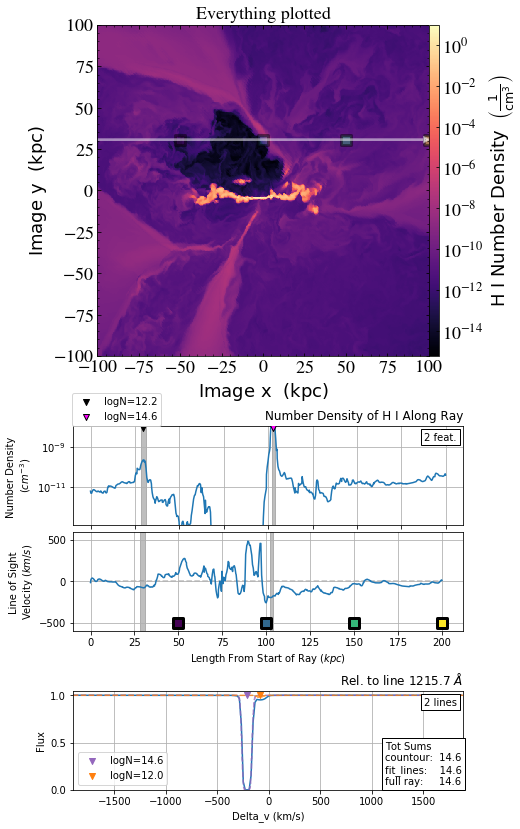

In [20]:
mp.fig

We can turn of some of the features with `mp.plot_contour` and `mp.plot_spectacle`. Also note that `mp.create_multi_plot()` returns the figure and axes that everything was plotted on so you can edit them like a regular matplotlib. (Warning!! the position of the plots are hard coded in so be careful if you mess with that)

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 564/564 [00:00<00:00, 2848.71it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -227.723 km / s (1215.67 Angstrom)
    Column density: 13.735, (5.4324e+13 1 / cm2)
    Doppler width: 55.7102 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -37.9419 km / s (1215.67 Angstrom)
    Column density: 11.9713, (1.17847e+12 1 / cm2)
    Doppler width: 32.6521 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -75.8886 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s
/mnt/home/boydbre1/local/yt-conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
spectacle [WARNING ]: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.



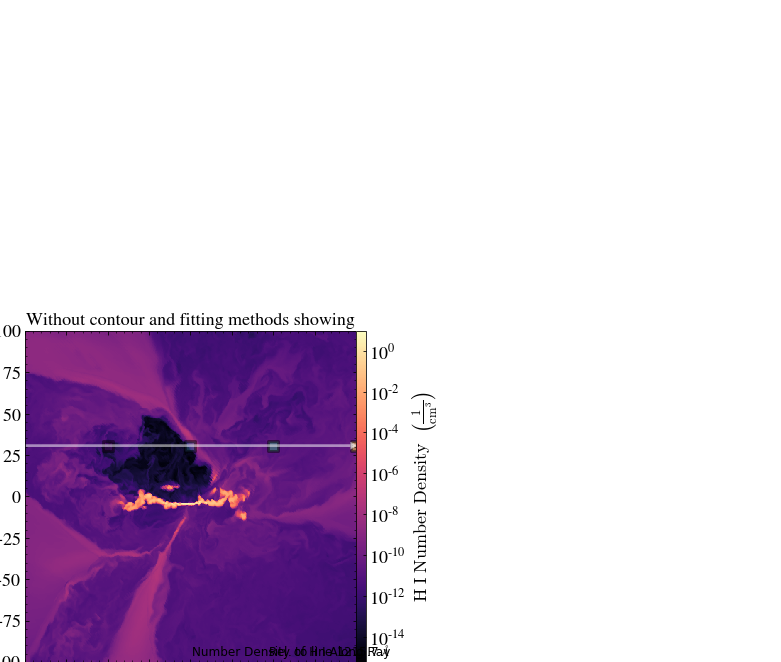

In [28]:
#clear the figure
mp.fig.clear()

#turn over plotting the two methods
mp.plot_contour = False
mp.plot_spectacle = False

fig, (ax1, ax2, ax3) = mp.create_multi_plot()

mp.slice.annotate_clear()
mp.add_annotations()
mp.slice.annotate_title("Without contour and fitting methods showing")

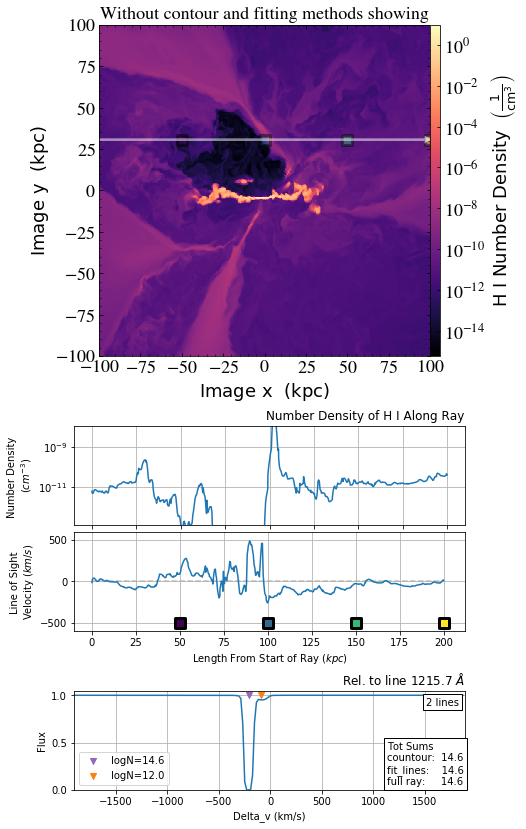

In [31]:
mp.fig